# Diffusion Models

In this exercise, we will be training a diffusion model and using it to conduct inference to generate images.

## Setup

Consider a simple UNet model, which which you have to train to predict the noise at each time step $t$ to denoise a given input $x_0$. If you have any questions, please contact *Sanjay Shakkottai* at: sanjay.shakkottai@utexas.edu

Thanks to *Lakshya Jagadish* for creating these exercises.

For references to the algorithms, please see:


**References:** https://arxiv.org/pdf/2006.11239.pdf

https://lilianweng.github.io/posts/2021-07-11-diffusion-models/

https://medium.com/@keshavarorasci/creating-simple-diffusion-model-from-scratch-in-tensorflow-eaf1e7a8c3a1

Goal of this exercise


1.   Download and use the MNIST dataset to train a diffusion model
2.   Implement the forward and backward processes according to Ho et al. 2020. Credit: https://arxiv.org/pdf/2006.11239.pdf
3.   Perform inference after training the model
4.   Fill in your answers wherever you see ...


In [ ]:
!pip install numpy torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import time
import random
import argparse
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from tqdm import tqdm
import torch.nn as nn
from torch.nn import functional as F

random.seed(1)

###Download the MNIST dataset

Apply a transform that
1. converts the image to a PyTorch tensor,
2. normalizes the image to have pixel values between [-1, 1]

In [ ]:
# 1. Define the transformation (to tensor and normalize to [-1, 1])
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts image to [0, 1]
    transforms.Normalize((0.5,), (0.5,))  # Scale to [-1, 1]
])

# 2. Download the MNIST training dataset with the transform
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 3. Create a list of 10,000 random indices
index_list = random.sample(range(len(train_dataset)), 10000)

# 4. Create a subset of the dataset using the index list
train_set = Subset(train_dataset, index_list)

# 5. Create a DataLoader
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.63MB/s]


Perform a sanity check to make sure you have the right data

Label: 5 | Channels: 1 | Height: 28px | Width: 28px


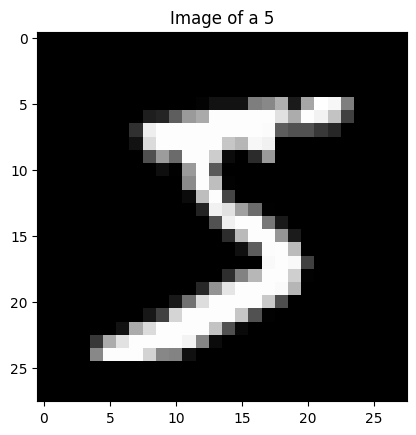

In [ ]:
# Sanity Check for images loaded
C = 1 # number of channels
W = 28 # width of image (pixels)
H = 28 # height of image (pixels)
image = train_dataset[0][0]
label  = train_dataset[0][1]

print(f"Label: {label} | Channels: {image.shape[0]} | Height: {image.shape[1]}px | Width: {image.shape[2]}px")
plt.imshow(image[0,:,:], cmap='gray') # remove first dimension (channels)
plt.title(f'Image of a {label}')
plt.show()

### Helper functions to sample and visualize images.

In [ ]:
# Function to show an image
def show_grid(imgs: List[np.ndarray], title=""):
    fig, ax = plt.subplots()
    imgs = [ (img - img.min()) / (img.max() - img.min()) for img in imgs ] # Normalize to [0, 1] for imshow()
    img = torchvision.utils.make_grid(imgs, padding=1, pad_value=1).numpy()
    ax.set_title(title)
    ax.imshow(np.transpose(img, (1, 2, 0)), cmap='gray')
    ax.set(xticks=[], yticks=[])
    plt.show()

In [ ]:
def sample_image(dataset):
    random.seed(3)
    # Sample random image from dataset
    # => x_0 ~ q(x)
    random_image_idx: int = random.randint(0, len(dataset) - 1)
    x = dataset[random_image_idx][0]
    return x

### Lets run a simple forward process on a randomly sampled image. Initialize the variables required for forward process and run it
$$T=50$$
$$\beta\{10^{-4},\cdots,10^{-1}\}$$
$$\alpha_t = 1-\beta_t$$
$$\hat{\alpha}_t = \Pi_{s=1}^t\alpha_t$$
$$\sigma_t^2=\beta_t$$
### Display the noisy image as well

### Initialize all the variables here. We will be using these precomputed coefficients throughout the assignment for the forward and backward processes.

In [ ]:
# 1. Number of timesteps
T = 50

# 2. Linearly spaced betas from 1e-4 to 1e-1
betas = torch.linspace(1e-4, 1e-1, T)

# 3. Compute alphas
alphas = 1.0 - betas

# 4. Compute cumulative product of alphas (alpha_bars)
alpha_bars = torch.cumprod(alphas, dim=0)

# 5. Sigmas (standard deviations for noise at each step)
sigmas = torch.sqrt(betas)

### Run an example forward process to understand what happens and visualize the outputs

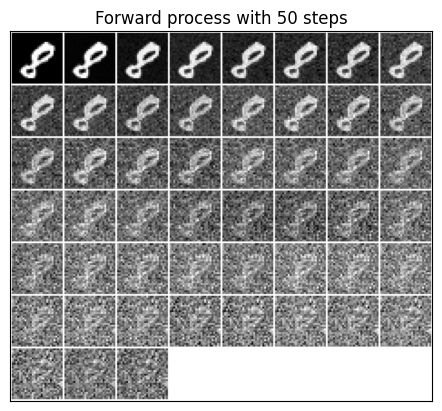

In [ ]:
# Run forward process
def fwd_process(x_0, T, betas):
    x_ts = []  # keep track of x_t's
    x_t_1 = x_0
    for t in range(T):
        # => e ~ N(0, I)
        epsilon = torch.randn_like(x_t_1)

        # => beta_t
        beta_t = betas[t]

        # => q(x_t | x_t_1) = N(x_t; sqrt(1 - beta_t) * x_t_1, beta_t * I)
        mean = torch.sqrt(1 - beta_t) * x_t_1
        std = torch.sqrt(beta_t)
        x_t = mean + std * epsilon  # sample from the normal distribution

        # Append current x_t to the list
        x_ts.append(x_t)

        # Continue sampling from this new x_t
        x_t_1 = x_t

    return x_ts

x_0 = sample_image(train_dataset)  # x_0
x_ts = fwd_process(x_0, T, betas)  # x_t's

# Show original + noised images
show_grid([x_0] + x_ts, title=f"Forward process with {T} steps")


### Based on the sample forward process you just implemented above, rewrite it to include it within the training loop.
### Reverse process to generate image from the noisy image
$$x_1 = \text{output of the forward process} $$
$$\epsilon_0 = \text{noise added to } x_0 $$
### Relevant variables from the forward process
$$\alpha_t = 1-\beta_t$$
$$\hat{\alpha}_t = \Pi_{s=1}^t\alpha_t$$
$$z_t \sim N(0,I) \text{ if } t>1 \text{ else } 0$$
### Use a diffusion model $\theta$ to estimate the noise added to $x_1$

### The model given below is a simple implementation of a UNet Model, which we will be using to train the diffusion model.
Do not change the model parameters as they have been adjusted to the MNIST dataset

In [ ]:
class Block(torch.nn.Module):
    def __init__(self, in_channels=128, size=28):
        super(Block, self).__init__()

        self.conv_param = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)
        self.conv_out = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)

        self.dense_ts = nn.Linear(192, 128)

        self.layer_norm = nn.LayerNorm([128, size, size])

    def forward(self, x_img, x_ts):
        x_parameter = F.relu(self.conv_param(x_img))

        time_parameter = F.relu(self.dense_ts(x_ts))
        time_parameter = time_parameter.view(-1, 128, 1, 1)
        x_parameter = x_parameter * time_parameter

        x_out = self.conv_out(x_img)
        x_out = x_out + x_parameter
        x_out = F.relu(self.layer_norm(x_out))

        return x_out

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.l_ts = nn.Sequential(
            nn.Linear(1, 192),
            nn.LayerNorm([192]),
            nn.ReLU(),
        )

        self.down_x28 = Block(in_channels=1, size=28)
        self.down_x14 = Block(size=14)
        self.down_x7 = Block(size=7)

        self.mlp = nn.Sequential(
            nn.Linear(6464, 128),
            nn.LayerNorm([128]),
            nn.ReLU(),

            nn.Linear(128, 32 * 7 * 7),
            nn.LayerNorm([32 * 7 * 7]),
            nn.ReLU(),
        )

        self.up_x7 = Block(in_channels=128+32, size=7)
        self.up_x14 = Block(in_channels=256, size=14)
        self.up_x28 = Block(in_channels=256, size=28)


        self.cnn_output = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, padding=0)

        # make optimizer
        self.opt = torch.optim.Adam(self.parameters(), lr=0.0008)

    def forward(self, x, x_ts):
        x_ts = x_ts.to(x.dtype)
        x_ts = self.l_ts(x_ts)

        # ----- left ( down ) -----
        blocks = [
            self.down_x28,
            self.down_x14,
            self.down_x7
        ]
        x_left_layers = []
        for i, block in enumerate(blocks):
            x = block(x, x_ts)
            x_left_layers.append(x)
            if i < len(blocks) - 1:
                x = F.max_pool2d(x, 2)

        # ----- MLP -----
        x = x.view(-1, 128 * 7 *7)
        x = torch.cat([x, x_ts], dim=1)
        x = self.mlp(x)
        x = x.view(-1, 32, 7, 7)

        # ----- right ( up ) -----
        blocks = [
            self.up_x7,
            self.up_x14,
            self.up_x28,
        ]

        for i, block in enumerate(blocks):
            # cat left
            x_left = x_left_layers[len(blocks) - i - 1]
            x = torch.cat([x, x_left], dim=1)

            x = block(x, x_ts)
            if i < len(blocks) - 1:
                x = F.interpolate(x, scale_factor=2, mode='bilinear')

        # ----- output -----
        x = self.cnn_output(x)

        return x





```
## This is formatted as code
```

### This training loop uses the forward process you implemented, while updating the UNet model above so that it learns to predict noise better. Algorithm below from Ho et. al., Denoising Diffusion Probabilistic Models, 2020. Credit: https://arxiv.org/pdf/2006.11239.pdf
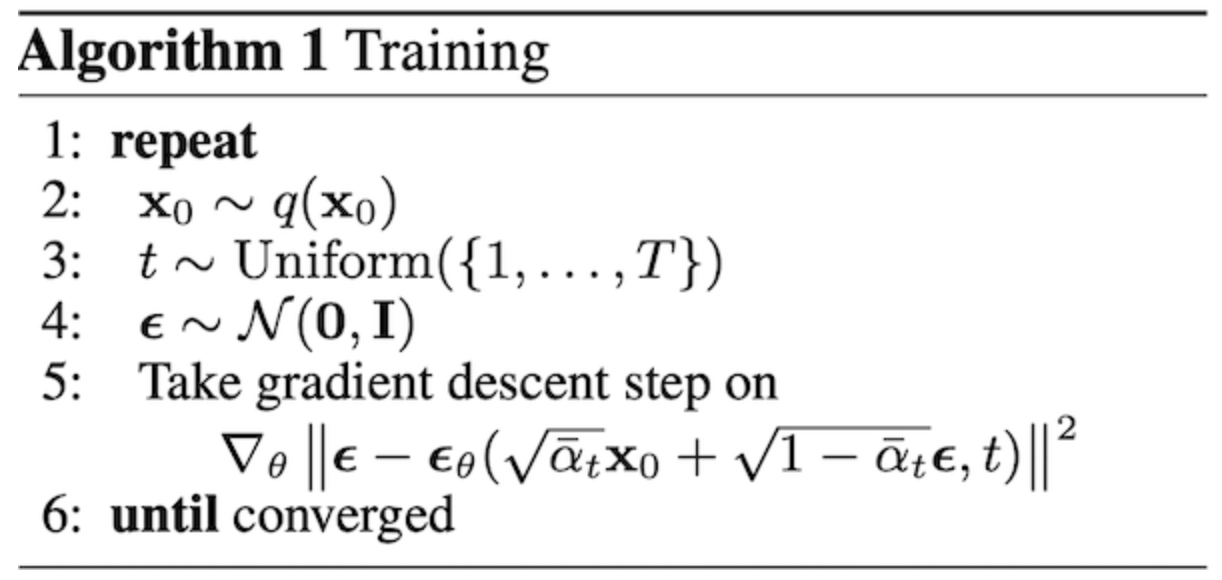
Implement the MSE loss to update the model weights with the optimizer (in our case we use torch's Adam optimizer).

In [ ]:
import torch
import time
import numpy as np
from typing import List

def train(model, optimizer, trainloader, T, alpha_bars, device):
    '''Train diffusion model.'''
    n_epochs = 2
    logging_steps = 100

    losses: List[float] = []
    model.train()
    for epoch in range(n_epochs):
        train_loss: float = 0.0
        start_time = time.time()

        for batch_idx, (x_0, _) in enumerate(trainloader):
            B = x_0.shape[0]  # batch size
            x_0 = x_0.to(device)

            # Sample t ~ Uniform(1, T) for each example in the batch
            t = torch.randint(1, T + 1, (B,), device=device).long()

            # Gather corresponding alpha_bar_t values
            #alpha_bar_t = alpha_bars[t].view(-1, 1, 1, 1).to(device)
            #alpha_bar_t = alpha_bars[t].view(B, 1, 1, 1).to(device)
            alpha_bar_t = alpha_bars[t - 1].view(B, 1, 1, 1).to(device)



            # Sample epsilon ~ N(0, I)
            epsilon = torch.randn_like(x_0)

            # Sample x_t = sqrt(alpha_bar_t) * x_0 + sqrt(1 - alpha_bar_t) * epsilon
            x_0_coef = torch.sqrt(alpha_bar_t)
            epsilon_coef = torch.sqrt(1 - alpha_bar_t)
            x_t = x_0_coef * x_0 + epsilon_coef * epsilon

            # Prepare x_ts (timestep as a continuous feature)
            x_ts = t.view(-1, 1).float().to(device)

            # Predict the noise added to x_0
            epsilon_theta = model(x_t, x_ts)

            # Compute the mean squared error loss between the predicted and true noise
            loss = torch.nn.functional.mse_loss(epsilon_theta, epsilon)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Logging
            losses.append(loss.item())
            train_loss += loss.item()
            if (batch_idx + 1) % logging_steps == 0:
                deno = logging_steps * B
                print(
                    'Loss over last {} batches: {:.4f} | Time (s): {:.4f}'.format(
                        logging_steps, (train_loss / deno), (time.time() - start_time))
                )
                train_loss = 0.0
                start_time = time.time()

    return model, losses


### Initialize the model, call the train function with appropriate arguments to train the model. This process will take a long time depending on the number of epochs run, so run the model with 2 epochs. Then use the pretrained model provided to run final inference.
Play around with the learning rate and see which one works best in a few epochs.

In [ ]:
# Create diffusion model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

# Train model
model, losses = train(model, optimizer, train_dataloader, T, alpha_bars, device)
torch.save(model.state_dict(), f'model.pt')

Loss over last 100 batches: 0.0043 | Time (s): 494.2445
Loss over last 100 batches: 0.0017 | Time (s): 495.0639


### Plot the training losses to understand if the model has learned

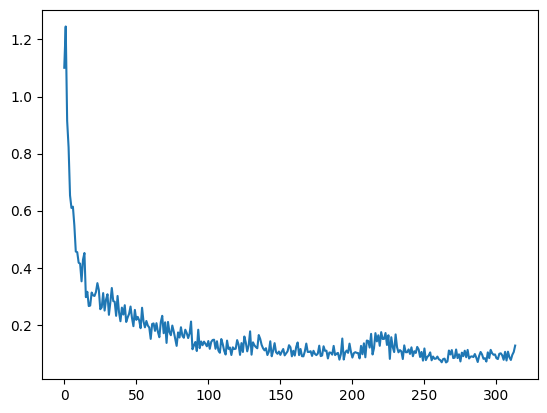

In [ ]:
plt.plot(losses)
plt.show()

### Use trained model to generate new samples of data
Implement the backward process of generating an image from a random distribution. Use the alphas and betas defined above while implementing the backward equations. Implement the forward and backward processes according to Ho et al., Denoising Diffusion Probabilistic Models, 2020. Credit: https://arxiv.org/pdf/2006.11239.pdf
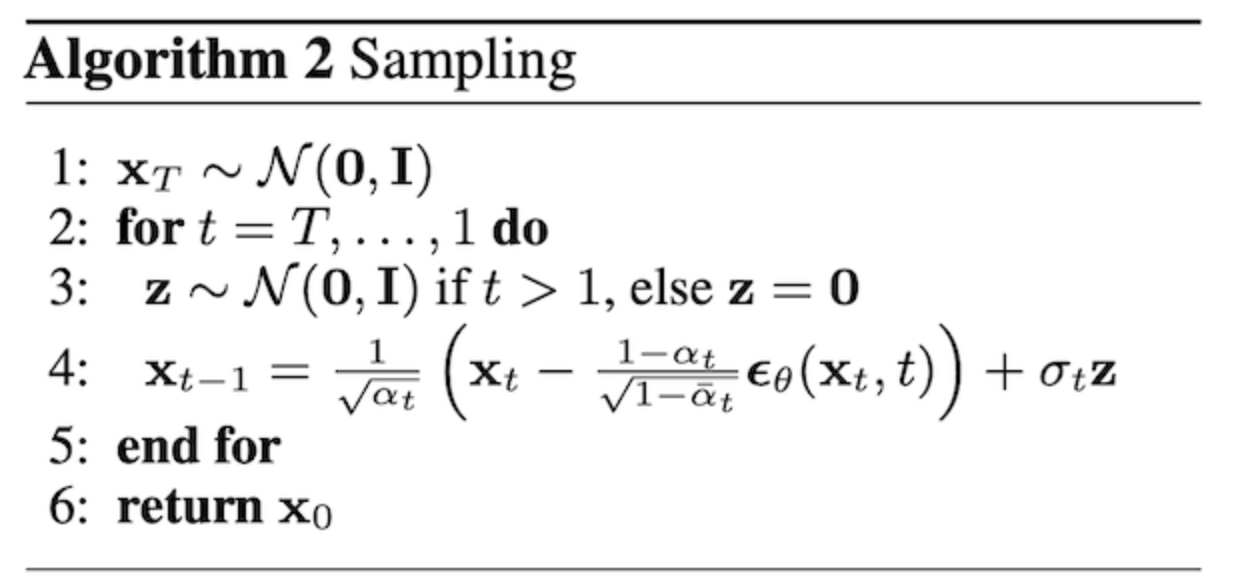

In [ ]:
def inference(model, n_samples, T, alphas, alpha_bars, sigmas, seed, device):
    '''Generate images from diffusion model.'''
    model.eval()
    torch.manual_seed(seed)
    # Dimensions
    n_channels = 1
    H, W = 28, 28 # 28 pixels for MNIST dataset
    # x_T ~ N(0, I)
    x_T = torch.randn(n_samples, n_channels, H, W).to(device)
    # For t = T ... 1
    x_t = x_T
    x_ts = [] # save image as diffusion occurs
    for t in tqdm(range(T-1, -1, -1)):
        # z ~ N(0, I) if t > 0 else z = 0
        z = torch.randn_like(x_t) if t > 0 else torch.zeros_like(x_t)
        # Setup terms for x_t-1
        t_vector = torch.full((n_samples, 1), t, device=device).float()
        t_vector = t_vector / T  # normalize timestep

        # Predict noise
        eps_theta = model(x_t, t_vector)

        # Compute x_{t-1}
        alpha_bar = alpha_bars[t]
        sigma = sigmas[t]
        x_t = (1 / torch.sqrt(alphas[t])) * (x_t - ((1 - alphas[t]) / torch.sqrt(1 - alpha_bar)) * eps_theta) + sigma * z
        x_ts.append(x_t.detach().cpu())

    return x_ts


### Load the  pretrained model provided and use it for inference. This code is set for n_samples = 2, but you can change it and infer more.

100%|██████████| 50/50 [00:03<00:00, 12.88it/s]


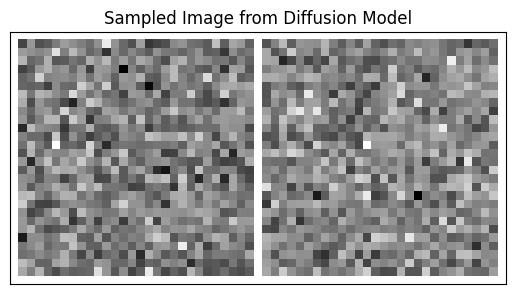

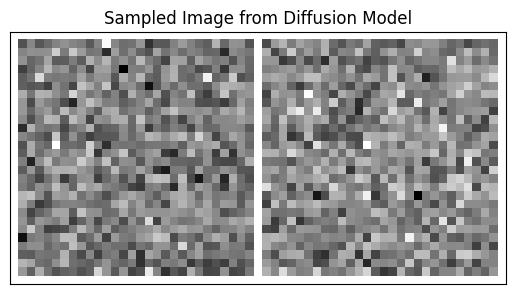

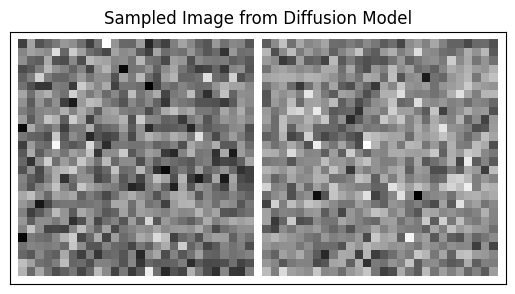

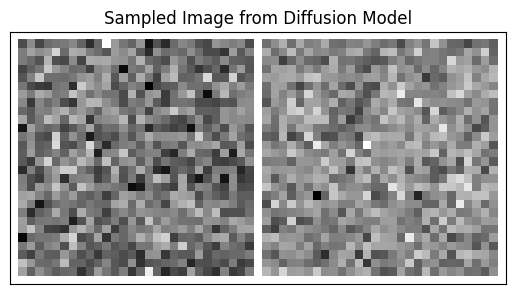

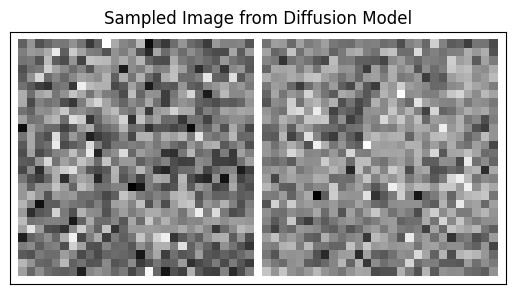

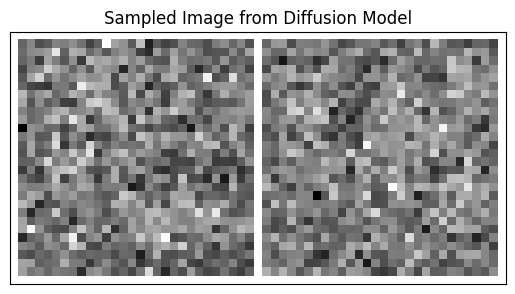

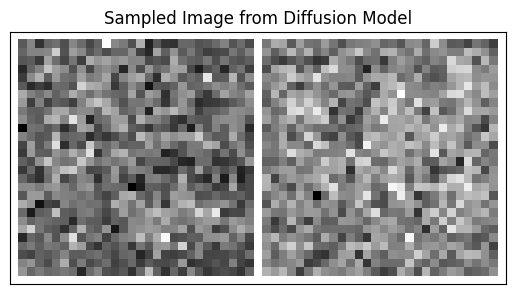

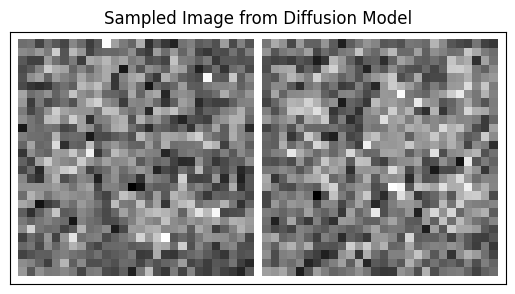

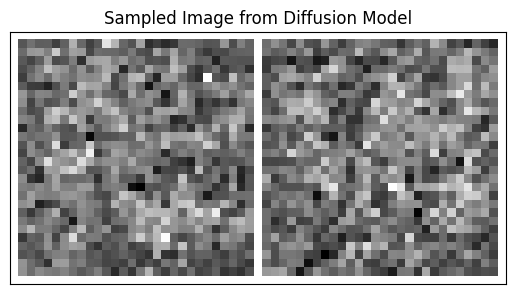

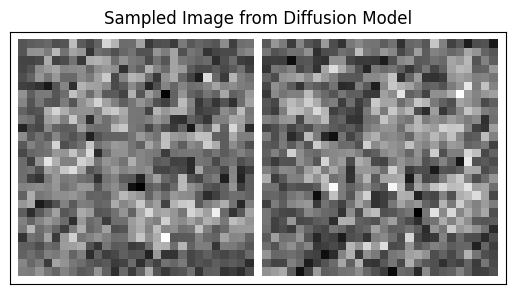

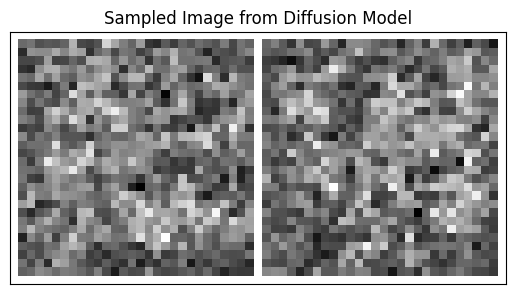

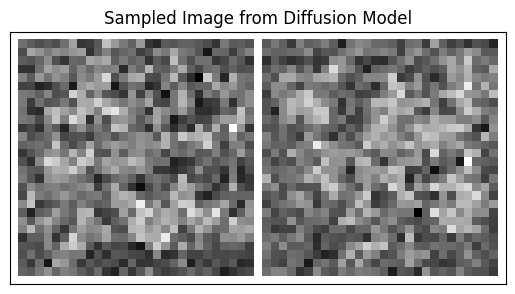

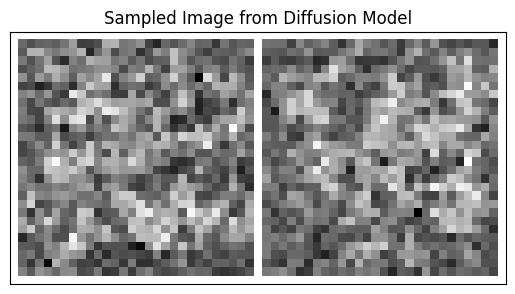

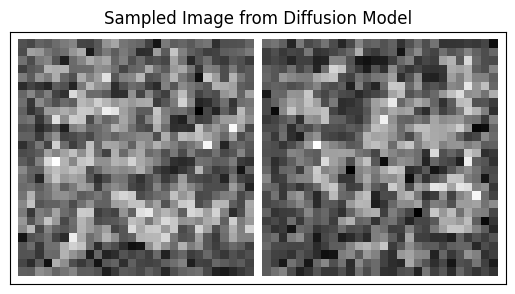

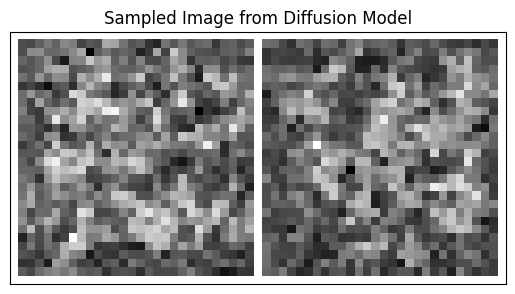

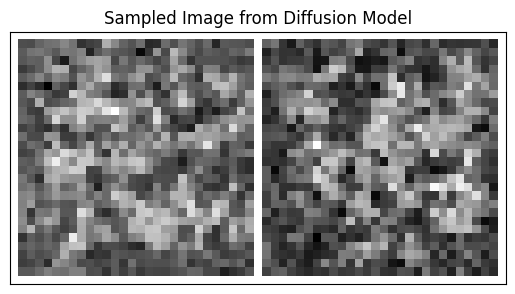

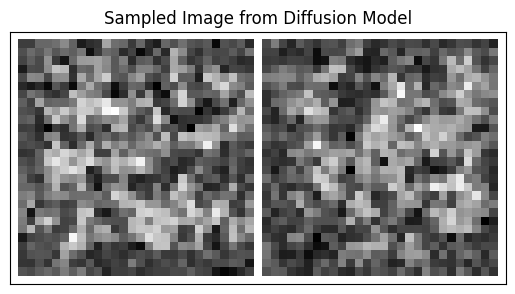

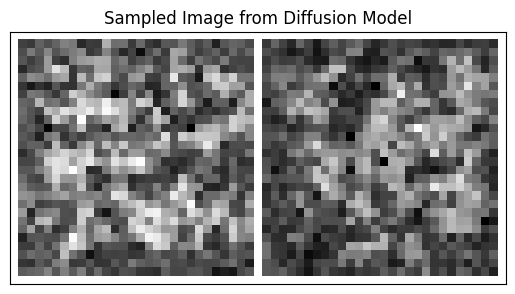

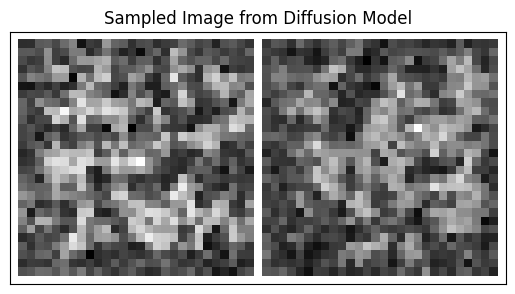

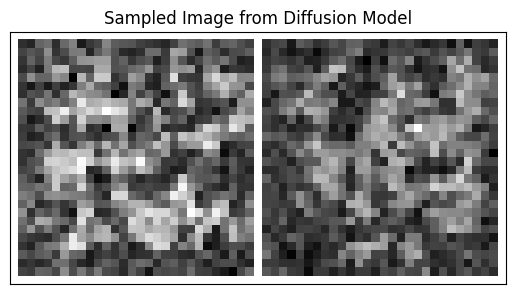

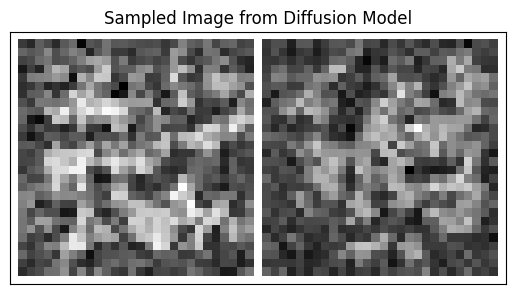

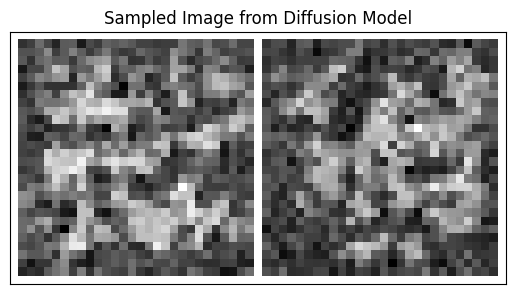

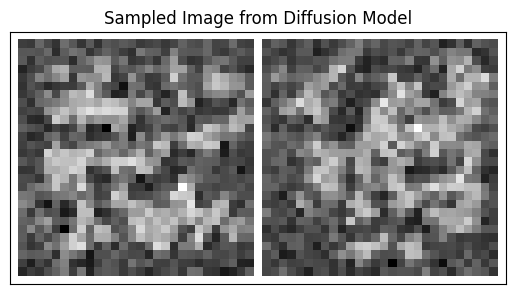

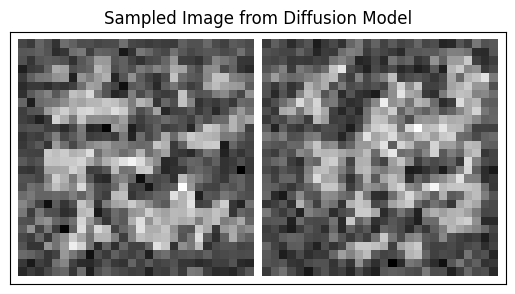

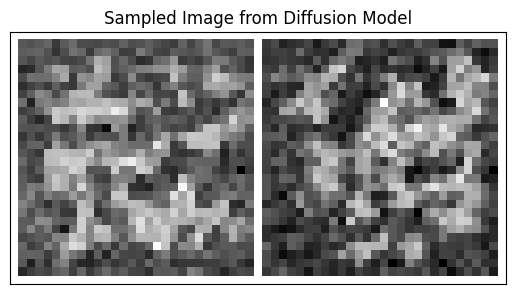

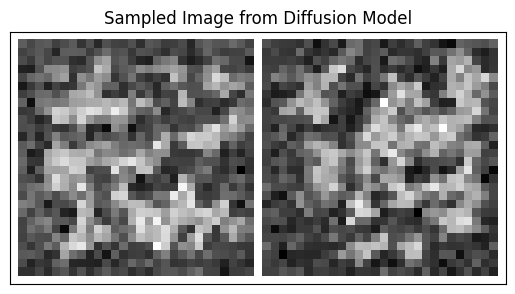

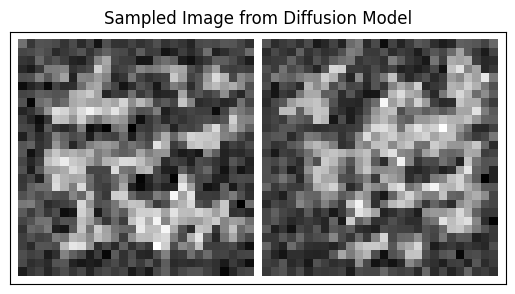

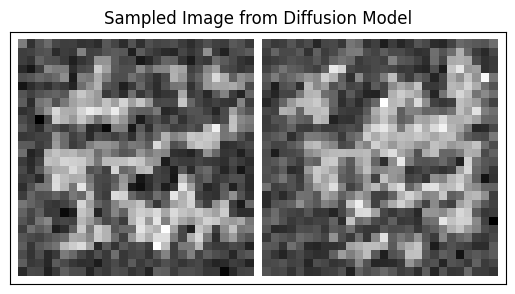

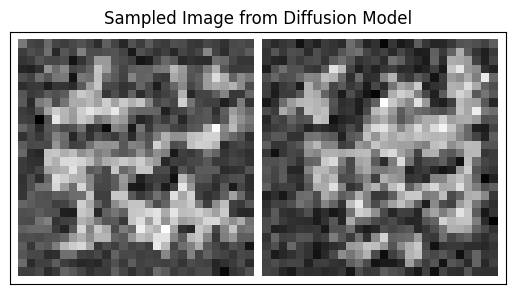

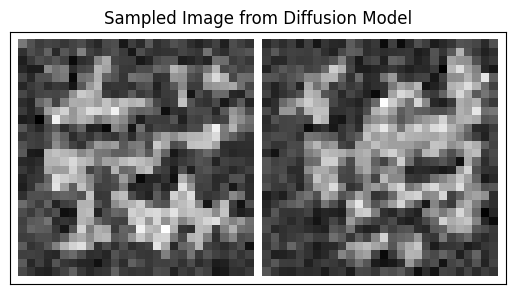

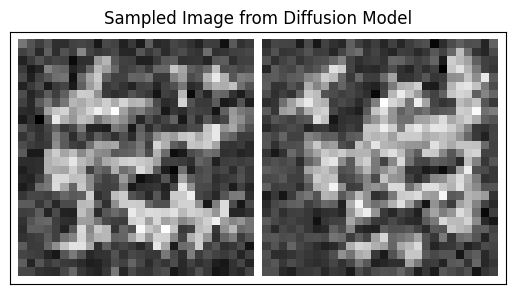

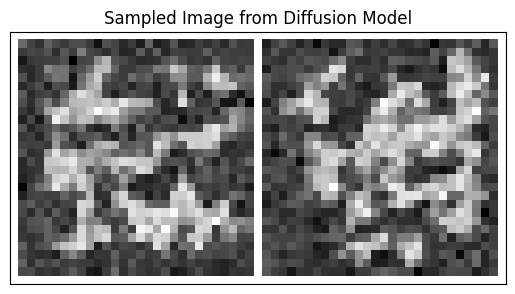

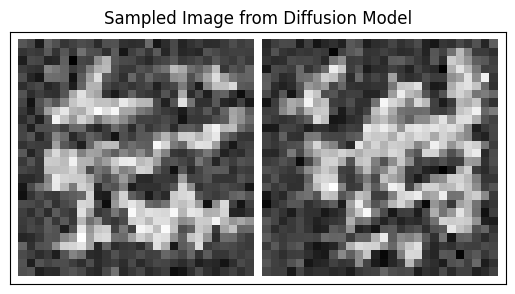

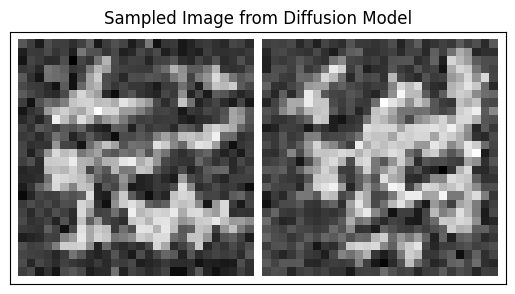

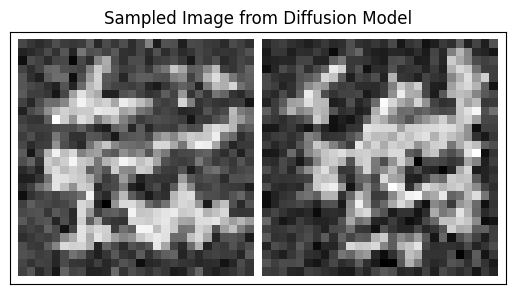

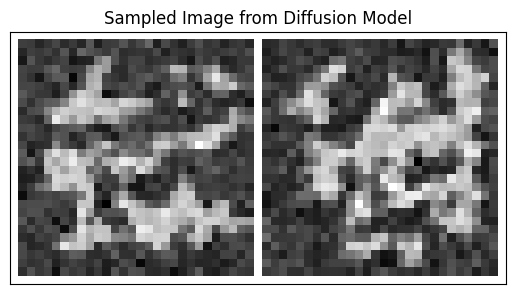

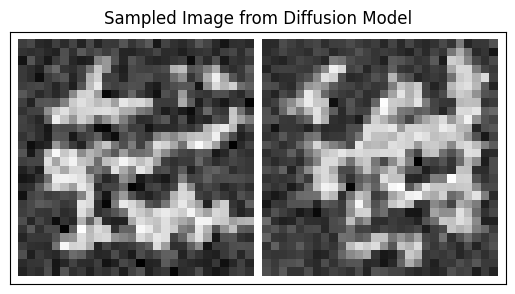

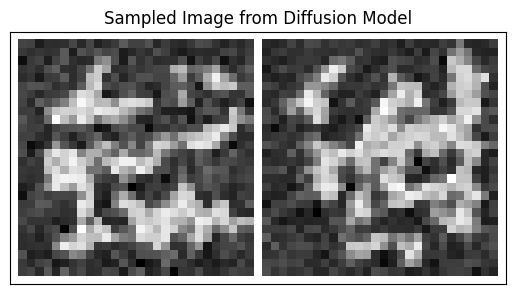

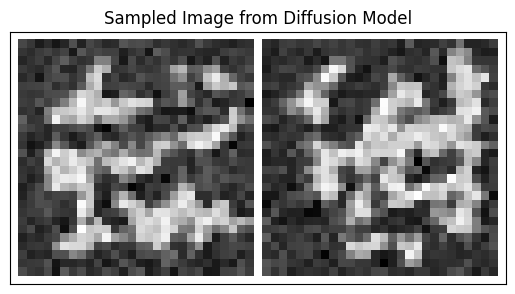

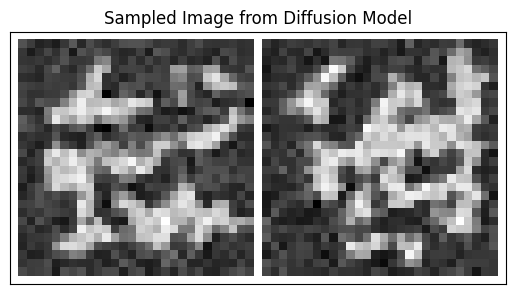

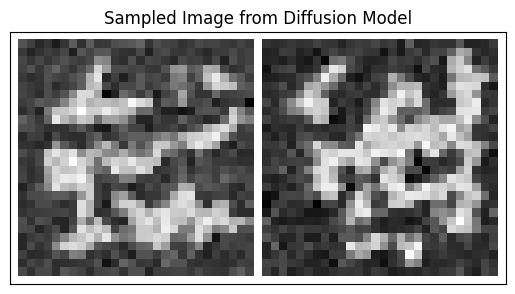

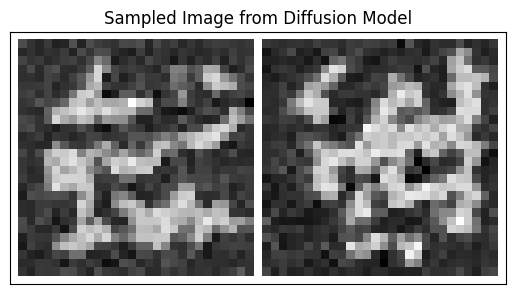

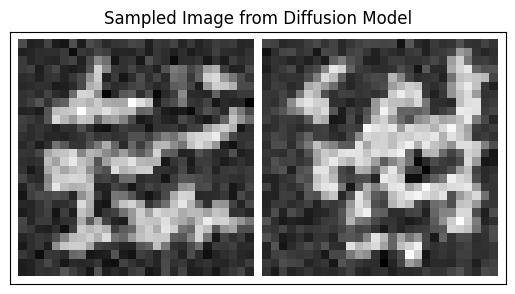

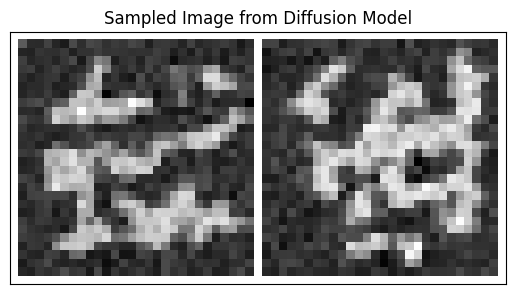

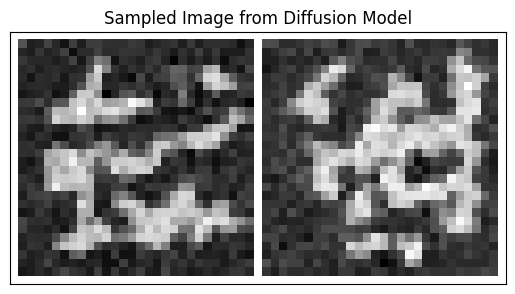

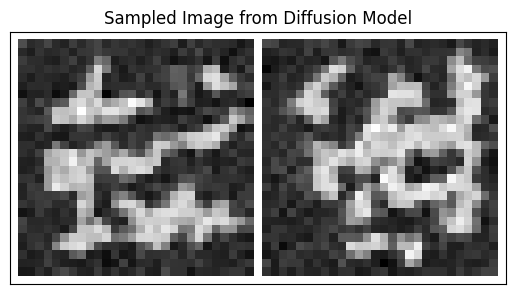

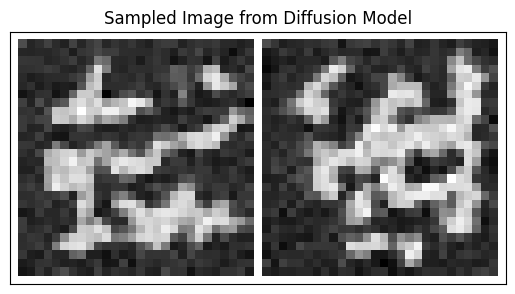

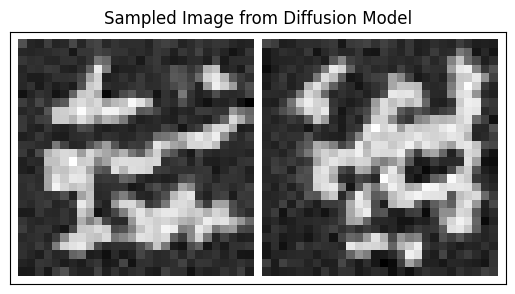

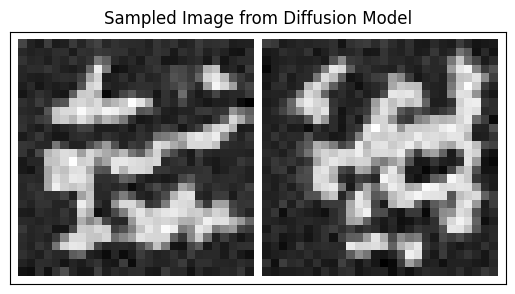

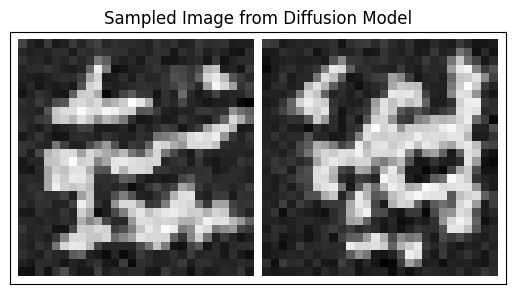

In [ ]:
# Load model
model.load_state_dict(torch.load('model.pt', map_location=device))
model.to(device)

sampled_images = inference(model, 2, T, alphas, alpha_bars, sigmas, seed=6, device=device)
for sample in sampled_images:
    show_grid(sample, title=f"Sampled Image from Diffusion Model")
    plt.show()
